In [1]:
!nvidia-smi

Mon May 27 18:22:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0    57W / 400W |   5640MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [2]:
import torch


# Function to list available GPUs and select one
def select_device():
    if torch.cuda.is_available():
        print("Available GPUs:")
        for i in range(torch.cuda.device_count()):
            print(f"{i}: {torch.cuda.get_device_name(i)}")
        device_id = int(input("Select GPU by entering the device ID (default 0): ") or 0)
        if device_id < torch.cuda.device_count():
            print(f"Using GPU: {torch.cuda.get_device_name(device_id)}")
            return torch.device(f"cuda:{device_id}")
        else:
            print(f"Invalid device ID. Using GPU: {torch.cuda.get_device_name(0)}")
            return torch.device("cuda:0")
    else:
        print("No GPU available. Using CPU.")
        return torch.device("cpu")

# Select the device
device = select_device()

Available GPUs:
0: NVIDIA A100-SXM4-40GB
1: NVIDIA A100-SXM4-40GB
2: NVIDIA A100-SXM4-40GB
3: NVIDIA A100-SXM4-40GB
4: NVIDIA A100-SXM4-40GB
5: NVIDIA A100-SXM4-40GB
6: NVIDIA A100-SXM4-40GB
7: NVIDIA A100-SXM4-40GB
Select GPU by entering the device ID (default 0): 3
Using GPU: NVIDIA A100-SXM4-40GB


In [3]:
import os
import torch
from transformers import DebertaV2ForSequenceClassification

# Function to load the model
def load_model(snapshot_path, model_name="microsoft/deberta-v3-large", num_labels=3):
    model = DebertaV2ForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.load_state_dict(torch.load(snapshot_path, map_location=device))
    model.to(device)
    return model

# Function to list all model snapshot files in a directory that match the naming pattern
def list_snapshot_files(snapshot_directory):
    return [os.path.join(snapshot_directory, file_name) for file_name in os.listdir(snapshot_directory) 
            if file_name.startswith('deberta_large_snli_cycle_') and file_name.endswith('.pth')]

# Load all models
snapshot_directory = '/storage/data/st1070263'
snapshot_files = list_snapshot_files(snapshot_directory)
model_snapshots = [load_model(snapshot) for snapshot in snapshot_files]

/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassif

In [4]:
import pandas as pd

# Path to the test data
test_data_path = 'SNLI/snli_1.0_test.csv'
df_snli_test = pd.read_csv(test_data_path)

# Select the necessary columns
df_snli_test = df_snli_test[['sentence1', 'sentence2', 'gold_label']]


df_snli_test

,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment
...,...,...,...
9995,Two women are observing something together.,Two women are standing with their eyes closed.,contradiction
9996,Two women are observing something together.,Two girls are looking at something.,entailment
9997,A man in a black leather jacket and a book in ...,A man is flying a kite.,contradiction
9998,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,entailment


In [5]:
# Convert sentences to lowercase
df_snli_test['sentence1'] = df_snli_test['sentence1'].str.lower()
df_snli_test['sentence2'] = df_snli_test['sentence2'].str.lower()

# Map textual labels to integers (ensure this matches your training setup)
label_mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
df_snli_test['gold_label'] = df_snli_test['gold_label'].map(label_mapping)

# Drop any rows with NaN values which may result from missing labels
df_snli_test.dropna(subset=['sentence1', 'sentence2', 'gold_label'], inplace=True)

# Convert 'gold_label' to integer type as it may be required by the model
df_snli_test['gold_label'] = df_snli_test['gold_label'].astype(int)


In [6]:
df_snli_test.head()

,sentence1,sentence2,gold_label
0,this church choir sings to the masses as they ...,the church has cracks in the ceiling.,1
1,this church choir sings to the masses as they ...,the church is filled with song.,0
2,this church choir sings to the masses as they ...,a choir singing at a baseball game.,2
3,"a woman with a green headscarf, blue shirt and...",the woman is young.,1
4,"a woman with a green headscarf, blue shirt and...",the woman is very happy.,0


In [7]:
df_snli_test['gold_label'].value_counts()

gold_label
0    3368
2    3237
1    3219
Name: count, dtype: int64

In [8]:
from transformers import DebertaV2Tokenizer
from torch.utils.data import DataLoader, Dataset
import torch

# Assuming the tokenizer has already been defined elsewhere in your notebook
# If not, reinitialize it here
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")

class SNLITestDataset(Dataset):
    """Dataset wrapping tensors for SNLI test data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize the test data
def tokenize_data(df, tokenizer):
    return tokenizer(df['sentence1'].tolist(), df['sentence2'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Prepare the test dataset
encodings = tokenize_data(df_snli_test, tokenizer)
test_dataset = SNLITestDataset(encodings, df_snli_test['gold_label'].tolist())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Adjust batch size based on your system's capability



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
from tqdm import tqdm
import torch

# Evaluate model and get predictions
def get_model_predictions(model, loader):
    model.eval()
    all_probs = []
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            all_probs.append(probabilities.detach())
    torch.cuda.empty_cache()
    return torch.cat(all_probs, dim=0)

model_probs = {}
for i, model in enumerate(model_snapshots):
    print(f"Processing Model {i+1}")
    probabilities = get_model_predictions(model, test_loader)
    model_probs[f'model_{i+1}_probs'] = probabilities.cpu().numpy()

Processing Model 1


Evaluating:   0%|                                                                                                                   | 0/307 [00:00<?, ?it/s]/tmp/ipykernel_3545869/1160642347.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Processing Model 2


Processing Model 3


Processing Model 4


Processing Model 5


In [10]:
# Save results
model_prob_df = pd.DataFrame()
for key, probs in model_probs.items():
    df_probs = pd.DataFrame(probs, columns=[f'{key}_class_0', f'{key}_class_1', f'{key}_class_2'])
    model_prob_df = pd.concat([model_prob_df, df_probs], axis=1)

model_prob_df.to_csv('model_probabilities.csv', index=False)
print("Model predictions stored in 'model_probabilities.csv'")

Model predictions stored in 'model_probabilities.csv'


In [11]:
model_prob_df

,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,model_4_probs_class_1,model_4_probs_class_2,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2
0,0.000022,0.999663,0.000314,0.003343,0.906081,0.090576,0.000167,0.997989,0.001844,0.000585,0.995493,0.003923,0.001595,0.978055,0.020350
1,0.995980,0.003844,0.000177,0.917467,0.081724,0.000809,0.960548,0.039345,0.000107,0.951923,0.047952,0.000125,0.919840,0.079596,0.000564
2,0.000010,0.000095,0.999895,0.000513,0.003150,0.996336,0.000012,0.000147,0.999841,0.000058,0.002089,0.997853,0.000028,0.002087,0.997885
3,0.000727,0.998957,0.000316,0.008057,0.984048,0.007895,0.007757,0.991744,0.000499,0.005010,0.994221,0.000769,0.010125,0.985627,0.004249
4,0.628596,0.370968,0.000436,0.211338,0.786251,0.002411,0.593029,0.406707,0.000264,0.573984,0.425537,0.000479,0.768164,0.231079,0.000757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9819,0.000092,0.000206,0.999703,0.001344,0.005083,0.993573,0.000033,0.000235,0.999732,0.000104,0.000663,0.999233,0.000039,0.000965,0.998996
9820,0.729662,0.267474,0.002863,0.967565,0.031584,0.000851,0.791097,0.206339,0.002564,0.889488,0.108095,0.002417,0.931429,0.065553,0.003018
9821,0.000009,0.000026,0.999965,0.000084,0.000366,0.999549,0.000006,0.000027,0.999967,0.000004,0.000033,0.999963,0.000011,0.000237,0.999752
9822,0.993974,0.004991,0.001035,0.985360,0.013930,0.000710,0.989409,0.010418,0.000173,0.988736,0.010913,0.000352,0.989736,0.009968,0.000296


In [12]:
# Add the true labels to the model probabilities DataFrame
model_prob_df['True_labels'] = df_snli_test['gold_label'].values

# Display the updated DataFrame to confirm the true labels are added correctly
model_prob_df.head()


,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,model_4_probs_class_1,model_4_probs_class_2,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2,True_labels
0,0.000022,0.999663,0.000314,0.003343,0.906081,0.090576,0.000167,0.997989,0.001844,0.000585,0.995493,0.003923,0.001595,0.978055,0.020350,1
1,0.995980,0.003844,0.000177,0.917467,0.081724,0.000809,0.960548,0.039345,0.000107,0.951923,0.047952,0.000125,0.919840,0.079596,0.000564,0
2,0.000010,0.000095,0.999895,0.000513,0.003150,0.996336,0.000012,0.000147,0.999841,0.000058,0.002089,0.997853,0.000028,0.002087,0.997885,2
3,0.000727,0.998957,0.000316,0.008057,0.984048,0.007895,0.007757,0.991744,0.000499,0.005010,0.994221,0.000769,0.010125,0.985627,0.004249,1
4,0.628596,0.370968,0.000436,0.211338,0.786251,0.002411,0.593029,0.406707,0.000264,0.573984,0.425537,0.000479,0.768164,0.231079,0.000757,0


In [13]:
import numpy as np

# Step 1: Calculate Individual Model Accuracy
def calculate_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Extract probabilities for each class and compute accuracy
accuracy_per_model = {}
n_models = 5  # Assuming you have 5 models, adjust if different
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    accuracy_per_model[f'model_{i}'] = calculate_accuracy(probs, model_prob_df['True_labels'].values)

# Step 2: Calculate Correlations Between Model Predictions
correlation_matrix = np.zeros((n_models, n_models))
for i in range(1, n_models + 1):
    for j in range(1, n_models + 1):
        # Extract the probabilities of the true class for correlation calculation
        true_class_probs_i = model_prob_df[[f'model_{i}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        true_class_probs_j = model_prob_df[[f'model_{j}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        correlation_matrix[i-1, j-1] = np.corrcoef(true_class_probs_i.ravel(), true_class_probs_j.ravel())[0, 1]

# Display results
print("Accuracy per model:", accuracy_per_model)
print("Correlation matrix between model predictions:\n", correlation_matrix)


Accuracy per model: {'model_1': 0.9230456026058632, 'model_2': 0.9268118892508144, 'model_3': 0.9226384364820847, 'model_4': 0.9254885993485342, 'model_5': 0.9270154723127035}
Correlation matrix between model predictions:
 [[1.         0.97035602 0.97836703 0.97721082 0.97125755]
 [0.97035602 1.         0.97200956 0.97682909 0.98048264]
 [0.97836703 0.97200956 1.         0.97838587 0.97371069]
 [0.97721082 0.97682909 0.97838587 1.         0.97869672]
 [0.97125755 0.98048264 0.97371069 0.97869672 1.        ]]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, title):
    """
    Plots a confusion matrix using seaborn based on the true labels and predictions provided.
    
    Parameters:
    - true_labels: Array-like of true labels.
    - predictions: Array-like of predictions.
    - title: Title for the plot.
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Accuracy of the averaged model: 0.9308835504885994
Categorical Cross-Entropy Loss of the averaged model: 0.20069196464482172


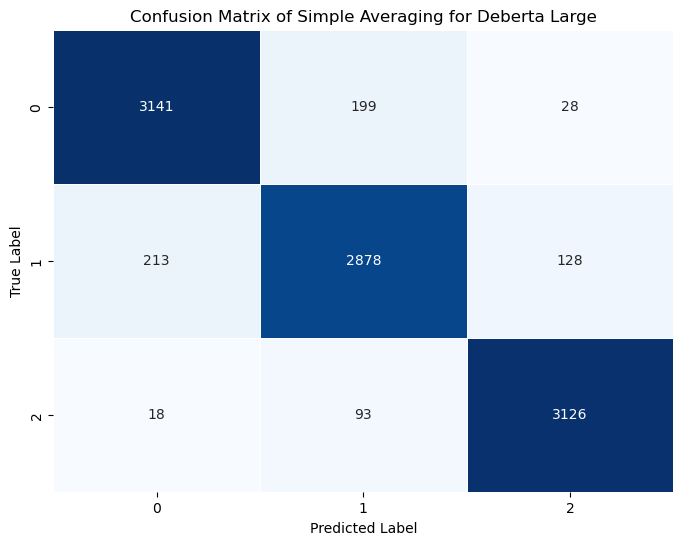

In [15]:
# Compute the average probabilities across all models
average_probs = np.mean([
    model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    for i in range(1, n_models + 1)
], axis=0)

# Determine predicted labels from the average probabilities
predicted_labels_from_average = np.argmax(average_probs, axis=1)

# Calculate accuracy of the averaged model
average_model_accuracy = np.mean(predicted_labels_from_average == model_prob_df['True_labels'].values)

print("Accuracy of the averaged model:", average_model_accuracy)

import numpy as np

def one_hot_encode(labels, num_classes):
    """ Convert array of labels to one-hot encoded numpy array. """
    return np.eye(num_classes)[labels]

def categorical_cross_entropy(true_labels, predicted_probs):
    """ Compute the categorical cross-entropy loss. """
    true_labels_one_hot = one_hot_encode(true_labels, num_classes=predicted_probs.shape[1])
    log_probs = np.log(predicted_probs + 1e-15)  # Adding a small epsilon to avoid log(0)
    loss = -np.sum(true_labels_one_hot * log_probs) / true_labels_one_hot.shape[0]
    return loss

# Assuming 'average_probs' is already calculated as suggested in the previous step
true_labels = model_prob_df['True_labels'].values
loss = categorical_cross_entropy(true_labels, average_probs)

print("Categorical Cross-Entropy Loss of the averaged model:", loss)

# Plotting the confusion matrix for the Simple Averaging method
plot_confusion_matrix(true_labels, predicted_labels_from_average, 'Confusion Matrix of Simple Averaging for Deberta Large')


Accuracy of the majority vote: 0.9300692182410424
Adjusted Categorical Cross-Entropy Loss for the majority vote: 0.3178515056908829


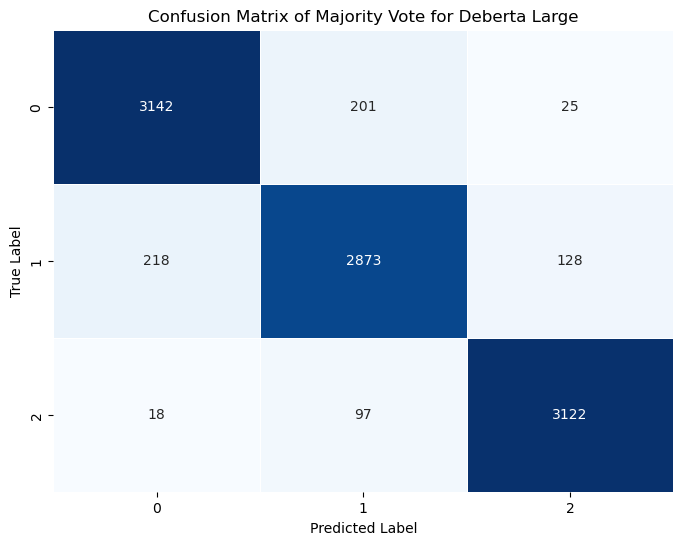

In [16]:
import numpy as np

# Assuming you have a DataFrame called 'model_prob_df' which includes the predicted probabilities for each class
# from each model and it looks something like this:
# Columns: ['model_1_probs_class_0', 'model_1_probs_class_1', 'model_1_probs_class_2', ..., 'model_5_probs_class_0', 'model_5_probs_class_1', 'model_5_probs_class_2', 'True_labels']

# Extract predicted labels for each model
predicted_labels = {}
n_models = 5  # Adjust the number of models based on your ensemble
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    predicted_labels[f'model_{i}'] = np.argmax(probs, axis=1)

# Constructing an array of all predictions
all_predictions = np.vstack([predicted_labels[f'model_{i}'] for i in range(1, n_models + 1)])

# Majority vote calculation
majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=3).argmax(), 0, all_predictions)

# Calculate the accuracy of the majority vote
true_labels = model_prob_df['True_labels'].values
majority_vote_accuracy = np.mean(majority_vote == true_labels)

print("Accuracy of the majority vote:", majority_vote_accuracy)
# Assuming majority_vote contains the predicted labels from your majority vote procedure
num_classes = 3  # Set this to the number of classes in your dataset
majority_vote_probs = one_hot_encode(majority_vote, num_classes)

def smooth_one_hot(true_labels, num_classes, smoothing=0.1):
    """
    Apply label smoothing. Default epsilon is 0.1.
    This helps to mitigate the issue with hard zero probabilities leading to infinite loss.
    """
    # Create an array where all elements are equal to a small value (smoothing / num_classes)
    confidence = 1.0 - smoothing
    smooth_prob = smoothing / num_classes
    one_hot_labels = np.eye(num_classes)[true_labels]
    return one_hot_labels * confidence + smooth_prob

# Calculate the smoothed probabilities for the majority vote predictions
majority_vote_smooth_probs = smooth_one_hot(majority_vote, num_classes, smoothing=0.05)  # Smoothing with a small epsilon value

# Calculate loss with the smoothed probabilities
loss = categorical_cross_entropy(true_labels, majority_vote_smooth_probs)

print("Adjusted Categorical Cross-Entropy Loss for the majority vote:", loss)


# Plotting the confusion matrix for the Majority Vote method
plot_confusion_matrix(true_labels, majority_vote, 'Confusion Matrix of Majority Vote for Deberta Large')
